<a href="https://colab.research.google.com/github/namwootree/Portfolio/blob/main/Competition/Kaggle/Scrabble%20Player%20Rating/Preprocessing_%26_Modeling(Optuna_%26_LGBM_reg).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reference

[Full Walkthrough (EDA + FE + Model Tuning)]('https://www.kaggle.com/code/ijcrook/full-walkthrough-eda-fe-model-tuning/notebook')

# Setting

## Install

In [1]:
!pip install textstat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 105 kB 11.5 MB/s 
     |████████████████████████████████| 2.0 MB 18.9 MB/s 


In [2]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 86 kB/s 


In [3]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 23.9 MB/s 
     |████████████████████████████████| 209 kB 43.5 MB/s 
     |████████████████████████████████| 81 kB 4.3 MB/s 
     |████████████████████████████████| 78 kB 860 kB/s 
     |████████████████████████████████| 50 kB 2.8 MB/s 
     |████████████████████████████████| 112 kB 23.8 MB/s 
     |████████████████████████████████| 147 kB 39.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=d5efd644d50b9e947b70a7e14b2cd72e91861b7d554be0d0f68c2232348a766e
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


## Library

In [4]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm
import os

import textstat

from sklearn.model_selection import cross_validate, KFold, RepeatedKFold
import category_encoders as ce

import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping, Dataset

import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import warnings
warnings.filterwarnings(action='ignore')

# Load Data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Unzip File

In [7]:
!unzip -qq '/content/drive/MyDrive/머신러닝 엔지니어링/Kaggle/Scrabble Player Rating/data/scrabble-player-rating.zip'

## Load Train / Test Data

In [8]:
def create_turn_features(df):

    # 타일 관련 변수 전처리
    df["rack_len"] = df["rack"].str.len() # rack (남은 타일)의 개수
    df["rack_len_less_than_7"] = df["rack_len"].apply(lambda x : x <7) # rack의 개수가 6개 이하 인 경우
    df["move_len"] = df["move"].str.len() # 배치한 타일 개수
    df["move"].fillna("None",inplace=True) # 결측치 처리
    # Dale–Chall readability formula 기준 어려운 단어
    df["difficult_word"] = df["move"].apply(textstat.difficult_words)
    
    # 해당 턴에 한 플레이 변수 전처리
    df["turn_type"].fillna("None",inplace=True) # 결측치 처리
    turn_type_unique = df["turn_type"].unique()
    df = pd.get_dummies(df, columns=["turn_type"]) # # 'turn_type' 변수 더미화

    # 더미화한 변수
    dummy_features = [f"turn_type_{value}" for value in turn_type_unique]
    
    # 타일 위치 관련 변수 전처리
    df['y'] = df["location"].str.extract('(\d+)')[0].values # 숫자만 (Y축 정보) 추출
    df['y'].fillna("0",inplace=True) # 결측치 처리
    df["y"] = df["y"].astype(int) # 데이터 타입 변경

    # X축 -> 숫자
    char_map = {
        'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8,
        'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15,
                }
    
    df["x"] = df["location"].str.extract('([A-Z])')[0].values # 글자만 (X축 정보) 추출
    df["x"].replace(char_map, inplace=True) # 숫자로 변경
    df['x'].fillna("0",inplace=True) # 결측치 처리
    df["x"] = df["x"].astype(int) # 데이터 타입 변경
    
    # 데이터의 첫 글자가 숫자인지 아닌지 여부
    df["direction_of_play"] = df["location"].apply(lambda x: 1 if str(x)[0].isdigit() else 0)
    
    # 타일의 위치 정보를 나타내지 않은 것의 개수 (. , (time) 등등)
    df["curr_board_pieces_used"] = df["move"].apply(lambda x: str(x).count(".") + sum(int(c.islower()) for c in str(x)))
    
    # 통계값을 활용한 전처리

    # 평균값을 구할 변수
    avg_features = ["points", "move_len", "difficult_word", "curr_board_pieces_used", "direction_of_play"]
    # 합계를 구할 변수
    sum_features = ["difficult_word", "rack_len_less_than_7"]+dummy_features
    # 최대값을 구할 변수
    max_features = ["move_len", "points"]
    agg_func = {feature:'sum' for feature in dummy_features}
    agg_func.update({
        "points":["mean", "max"],
        "move_len":["mean", "max"],
        "difficult_word":["mean", "sum"],
        "curr_board_pieces_used": "mean",
        "direction_of_play": "mean",
        "rack_len_less_than_7" : "sum"
    }
    )

    turns_grouped = df.groupby(["game_id", "nickname"], as_index=False).agg(agg_func)
    
    turns_grouped.columns = ["_".join(a) if a[0] not in ["game_id", "nickname"] else a[0] for a in turns_grouped.columns.to_flat_index()]
    
    print('DONE : create_turn_features')

    return turns_grouped

In [9]:
def load_data(bot_names =["BetterBot", "STEEBot", "HastyBot", "MasterBot"], cat_features=[]):
    
    # 파일 경로
    ROOT_DIR = '/content/'
    
    # 데이터 불러오기
    train = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
    test = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))
    turns = pd.read_csv(os.path.join(ROOT_DIR, "turns.csv"))
    games = pd.read_csv(os.path.join(ROOT_DIR, "games.csv"))
    
    # Train & Test 데이터 셋 결합
    df = pd.concat([train, test])
    
    # 전처리
    
    # turns 데이터 전처리
    turns_fe_df = create_turn_features(turns)

    # 전처리된 turns 데이터 결합
    df = df.merge(turns_fe_df, how="left", on=["game_id", "nickname"])
    
    # Bot 관련된 데이터 플레임 생성
    bot_df = df[["game_id", "nickname", "score", "rating"]].copy()
    bot_df['bot_name'] = bot_df['nickname'].apply(lambda x: x if x in bot_names else np.nan)
    bot_df = bot_df[["game_id", "score", "rating", "bot_name"]].dropna(subset=["bot_name"])
    bot_df.columns = ["game_id", "bot_score", "bot_rating", "bot_name"]
    
    # Human 관련된 데이터 플레임 생성 및 Bot 관련된 데이터 & games 데이터 결합
    df = df[~df['nickname'].isin(bot_names)] # Human 관련된 데이터 플레임 생성
    df = df.merge(bot_df, on="game_id") # Bot 관련된 데이터 결합
    df = df.merge(games, on="game_id") # games 관련된 데이터 결합
    df["created_at"] = pd.to_datetime(df["created_at"]) # 데이터 타임 수정
    
    # 랭킹 1500등 계정 전처리
    users= df[df["rating"]==1500]["nickname"]
    anamolous = df[df["nickname"].isin(users)].groupby("nickname").agg({'nickname':'count',
                                                         'rating' : lambda x : np.sum(x == 1500)
                                                         })
    
    # 이상치 제거 : 1500등이 비정상적으로 많음

    # 랭킹 1500등에 달성할 확률 
    anamolous["ratio"] = anamolous["rating"] / anamolous["nickname"]

    # 너무 잘하는 유저
    anamolous_users = anamolous[(anamolous["ratio"] >=1.0) & (anamolous["nickname"]>1)].index

    # 이상치 제거
    df = df[~df["nickname"].isin(anamolous_users)]
    
    # 범주형 데이터 지정
    for name in cat_features:
        df[name] = df[name].astype("category")

        # 카테고리에 'None'값 추가
        # if "None" not in df[name].cat.categories:
        #     df[name].cat.add_categories("None", inplace=True)

    # Split Train / Test
    train = df[df["game_id"].isin(train["game_id"])].set_index("game_id")
    test = df[df["game_id"].isin(test["game_id"])].set_index("game_id")

    print('\nDONE : load_data\n')

    return train, test

In [10]:
cat_features = ["nickname","bot_name", 
                "time_control_name", "first",
                "game_end_reason", "winner",
                "lexicon", "rating_mode"]

train, test = load_data(cat_features = cat_features)

DONE : create_turn_features

DONE : load_data



In [11]:
train.head()

,nickname,score,rating,turn_type_Play_sum,turn_type_End_sum,turn_type_Exchange_sum,turn_type_Pass_sum,turn_type_Timeout_sum,turn_type_Challenge_sum,turn_type_Six-Zero Rule_sum,...,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds
game_id,,,,,,,,,,,,,,,,,,,,,
3,davidavid,440,1811.0,13,1,0,0,0,0,0,...,regular,STANDARD,1,2022-09-04 08:04:27,CSW21,900,0,RATED,5,492.268262
4,Inandoutworker,119,1473.0,12,0,2,0,0,0,0,...,regular,RESIGNED,0,2022-09-12 02:36:19,CSW21,3600,0,CASUAL,1,350.861141
6,HivinD,378,2029.0,12,0,0,0,0,0,0,...,regular,STANDARD,0,2022-08-21 14:56:35,CSW21,900,0,RATED,1,426.950541
8,AliSalman1,414,2067.0,11,0,0,0,0,0,0,...,regular,STANDARD,0,2022-09-06 21:03:24,CSW21,900,0,RATED,1,458.019893
9,cccc,364,1641.0,13,1,1,0,0,0,0,...,regular,STANDARD,0,2022-09-02 01:55:00,NWL20,1200,0,RATED,1,567.144135


In [12]:
test.head()

,nickname,score,rating,turn_type_Play_sum,turn_type_End_sum,turn_type_Exchange_sum,turn_type_Pass_sum,turn_type_Timeout_sum,turn_type_Challenge_sum,turn_type_Six-Zero Rule_sum,...,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds
game_id,,,,,,,,,,,,,,,,,,,,,
2,Super,488,NaN,11,1,1,1,0,0,0,...,regular,STANDARD,1,2022-08-10 19:19:59,CSW21,3600,0,RATED,1,364.214418
7,Priya1,379,NaN,12,0,1,0,0,0,0,...,regular,STANDARD,1,2022-08-26 03:07:48,CSW21,1260,0,RATED,1,385.599607
11,TileRunner,462,NaN,13,0,1,0,0,0,0,...,regular,STANDARD,1,2022-08-22 01:13:10,NWL20,1200,0,CASUAL,1,501.739156
14,Anfield223,359,NaN,14,1,0,0,0,0,0,...,regular,STANDARD,0,2022-09-14 14:06:24,CSW21,900,0,RATED,1,293.253051
27,friesbasil,456,NaN,11,0,0,0,0,0,0,...,regular,STANDARD,1,2022-09-13 09:12:15,CSW21,1200,0,RATED,1,203.963230


# Preprocessing

In [13]:
# 간단한 모델 생성을 통한 전처리에 따른 성능 확인

def score_dataset(X, y, 
                  model=LGBMRegressor(n_estimators=1000, 
                                      verbose=-1,
                                      random_state=42)
                 ):
    
    scores = cross_validate(
                  model,
                  X, y,
                  cv=5,
                  n_jobs=-1,
                  scoring='neg_root_mean_squared_error', return_train_score=True
                            )
    
    return {"Training":-1*np.mean(scores["train_score"]), "Validation":-1*np.mean(scores["test_score"])}

## create_cumm_player_features_overall

In [14]:
def create_cumm_player_features_overall(df):

    df = df[["nickname", "created_at","score","winner", "game_duration_seconds"]]
    
    df= df.sort_values(by="created_at")

    #Initialize our new variables with 0's
    df["cumm_avg_player_score"] = np.zeros(len(df))
    df["cumm_player_wins"] = np.zeros(len(df))
    df["cumm_avg_player_win_ratio"] = np.zeros(len(df))
    df["cumm_avg_game_duration_seconds"] = np.zeros(len(df))

    # 닉네임 별
    for nickname in tqdm(df["nickname"].unique()):

        # 게임이 플레이 되기 전에는 현재의 데이터를 알 수 없기에 이전 데이터를 활용함
        
        # 플레이어 평균 점수
        df.loc[df["nickname"]==nickname, "cumm_avg_player_score"]= np.append(0, df[df["nickname"]==nickname]["score"].expanding(min_periods=1).mean().values[:-1])
        
        # 플레이어 우승 횟수 (우승 : 1, 무승부 : 0, 패배 : -1)
        df.loc[df["nickname"]==nickname, "cumm_player_wins"]= np.append(0, df[df["nickname"]==nickname]["winner"].expanding(min_periods=1).sum().values[:-1])
        
        # 플레이어 우승 비율 (우승 횟수 / 경기 수)
        df.loc[df["nickname"]==nickname, "cumm_avg_player_win_ratio"]= \
        df[df["nickname"]==nickname]["cumm_player_wins"] / np.append(0, df[df["nickname"]==nickname]["winner"].expanding(min_periods=1).count().values[:-1])
        
        # 플레이어 평균 경기 시간
        df.loc[df["nickname"]==nickname, "cumm_avg_game_duration_seconds"]= \
        np.append(0, df[df["nickname"]==nickname]["game_duration_seconds"].expanding(min_periods=2).mean().values[:-1])
        
    # 결측치 처리
    df[["cumm_avg_player_score", "cumm_player_wins", "cumm_avg_player_win_ratio", "cumm_avg_game_duration_seconds"]]\
    = df[["cumm_avg_player_score", "cumm_player_wins", "cumm_avg_player_win_ratio", "cumm_avg_game_duration_seconds"]].fillna(0)
    
    df = df.sort_index()
    
    print('DONE : create_cumm_player_features_overall')

    return df[["cumm_avg_player_score", "cumm_player_wins", "cumm_avg_player_win_ratio", "cumm_avg_game_duration_seconds"]]

In [15]:
# 천처리한 변수만 사용하여 모델링
X = create_cumm_player_features_overall(train.copy())
y = train["rating"]

  0%|          | 0/1007 [00:00<?, ?it/s]

DONE : create_cumm_player_features_overall


In [16]:
score_dataset(X, y)

{'Training': 70.77174335271148, 'Validation': 91.19315139825274}

## create_cumm_player_features_bot

In [17]:
def create_cumm_player_features_bot(df):

    df= df[["nickname", "created_at","score","winner","bot_name", "game_duration_seconds"]]
    
    df= df.sort_values(by="created_at")

    for bot_name in df["bot_name"].unique():
        df["cumm_avg_player_score_"+str(bot_name)] = np.zeros(len(df))
        df["cumm_player_wins_"+str(bot_name)] = np.zeros(len(df))
        df["cumm_avg_player_win_ratio_"+str(bot_name)] = np.zeros(len(df))
        df["cumm_avg_game_duration_seconds_"+str(bot_name)] = np.zeros(len(df))

    for nickname in tqdm(df["nickname"].unique()):
        
        # 상대 Bot 별
        for bot_name in df["bot_name"].unique():
            
            # 게임이 플레이 되기 전에 현재 데이터 값을 알 수 없기에 이전 데이터를 활용함

            # 플레이어 평균 점수
            df.loc[(df["nickname"]==nickname) & (df["bot_name"]==bot_name), "cumm_avg_player_score_"+str(bot_name)]= \
            np.append(0, df[(df["nickname"]==nickname) & (df["bot_name"]==bot_name)]["score"].expanding(min_periods=1).mean().values[:-1])
            
            # 플레이어 우승 횟수 (우승 : 1, 무승부 : 0, 패배 : -1)
            df.loc[(df["nickname"]==nickname) & (df["bot_name"]==bot_name), "cumm_player_wins_"+str(bot_name)]= \
            np.append(0, df[(df["nickname"]==nickname) & (df["bot_name"]==bot_name)]["winner"].expanding(min_periods=1).sum().values[:-1])
            
            # 플레이어 평균 우승 비율
            df.loc[(df["nickname"]==nickname) & (df["bot_name"]==bot_name), "cumm_avg_player_win_ratio_"+str(bot_name)]= \
            df[(df["nickname"]==nickname) & (df["bot_name"]==bot_name)]["cumm_avg_player_win_ratio_"+str(bot_name)] / np.append(0, df[(df["nickname"]==nickname) & (df["bot_name"]==bot_name)]["winner"].expanding(min_periods=1).count().values[:-1])
            
            # 플레이어 평균 경기 시간
            df.loc[(df["nickname"]==nickname) & (df["bot_name"]==bot_name), "cumm_avg_game_duration_seconds_"+str(bot_name)]= \
            np.append(0, df[(df["nickname"]==nickname) & (df["bot_name"]==bot_name)]["game_duration_seconds"].expanding(min_periods=1).mean().values[:-1])
            
    #fill in any missing values with 0
    for bot_name in df["bot_name"].unique():
        df[["cumm_avg_player_score_"+str(bot_name), "cumm_player_wins_"+str(bot_name), "cumm_avg_player_win_ratio_"+str(bot_name), "cumm_avg_game_duration_seconds_"+str(bot_name)]] = \
        df[["cumm_avg_player_score_"+str(bot_name), "cumm_player_wins_"+str(bot_name), "cumm_avg_player_win_ratio_"+str(bot_name), "cumm_avg_game_duration_seconds_"+str(bot_name)]].fillna(0)
    
    # resort the data by the the index (i.e. game number)
    df = df.sort_index()

    print('DONE : create_cumm_player_features_bot')
    
    # 아래의 변수가 없는 변수들만 사용
    return df[df.columns.difference(["nickname", "created_at","score","winner","bot_name", "game_duration_seconds"])]

In [18]:
X = create_cumm_player_features_bot(train.copy())
y = train["rating"]

  0%|          | 0/1007 [00:00<?, ?it/s]

DONE : create_cumm_player_features_bot


In [19]:
score_dataset(X, y)

{'Training': 79.21783371130178, 'Validation': 98.52140739681428}

## create_cumm_player_features_lexicon

In [20]:
def create_cumm_player_features_lexicon(df):

    df= df[["nickname", "created_at","score","winner","lexicon",  "game_duration_seconds"]]

    df= df.sort_values(by="created_at")

    for lexicon in df["lexicon"].unique():
        df["cumm_avg_player_score_"+str(lexicon)] = np.zeros(len(df))
        df["cumm_player_wins_"+str(lexicon)] = np.zeros(len(df))
        df["cumm_avg_player_win_ratio_"+str(lexicon)] = np.zeros(len(df))
        df["cumm_avg_game_duration_seconds_"+str(lexicon)] = np.zeros(len(df))

    for nickname in tqdm(df["nickname"].unique()):

        # 사용한 어휘 사전 별
        for lexicon in df["lexicon"].unique():

            # 게임이 플레이 되기 전에 현재 데이터 값을 알 수 없기에 이전 데이터를 활용함
            
            # 플레이어 평균 점수
            df.loc[(df["nickname"]==nickname) & (df["lexicon"]==lexicon), "cumm_avg_player_score_"+str(lexicon)]= \
            np.append(0, df[(df["nickname"]==nickname) & (df["lexicon"]==lexicon)]["score"].expanding(min_periods=1).mean().values[:-1])
            
            # 플레이어 우승 횟수 (우승 : 1, 무승부 : 0, 패배 : -1)
            df.loc[(df["nickname"]==nickname) & (df["lexicon"]==lexicon), "cumm_player_wins_"+str(lexicon)]= \
            np.append(0, df[(df["nickname"]==nickname) & (df["lexicon"]==lexicon)]["winner"].expanding(min_periods=1).sum().values[:-1])
            
            # 플레이어 평균 우승 비율
            df.loc[(df["nickname"]==nickname) & (df["lexicon"]==lexicon), "cumm_avg_player_win_ratio_"+str(lexicon)]= \
            df[(df["nickname"]==nickname) & (df["lexicon"]==lexicon)]["cumm_avg_player_win_ratio_"+str(lexicon)] / np.append(0, df[(df["nickname"]==nickname) & (df["lexicon"]==lexicon)]["winner"].expanding(min_periods=1).count().values[:-1])
            
            # 플레이어 평균 경기 시간
            df.loc[(df["nickname"]==nickname) & (df["lexicon"]==lexicon), "cumm_avg_game_duration_seconds_"+str(lexicon)]= \
            np.append(0, df[(df["nickname"]==nickname) & (df["lexicon"]==lexicon)]["game_duration_seconds"].expanding(min_periods=1).mean().values[:-1])

    # 결측치 처리
    for lexicon in df["lexicon"].unique():
        df[["cumm_avg_player_score_"+str(lexicon), "cumm_player_wins_"+str(lexicon), "cumm_avg_player_win_ratio_"+str(lexicon), "cumm_avg_game_duration_seconds_"+str(lexicon)]] = \
        df[["cumm_avg_player_score_"+str(lexicon), "cumm_player_wins_"+str(lexicon), "cumm_avg_player_win_ratio_"+str(lexicon), "cumm_avg_game_duration_seconds_"+str(lexicon)]].fillna(0)
    
    df = df.sort_index()

    print('DONE : create_cumm_player_features_lexicon')

    # 아래의 변수가 없는 변수들만 사용
    return df[df.columns.difference(["nickname", "created_at","score","winner","lexicon", "game_duration_seconds"])]

In [21]:
X = create_cumm_player_features_lexicon(train.copy())
y = train["rating"]

  0%|          | 0/1007 [00:00<?, ?it/s]

DONE : create_cumm_player_features_lexicon


In [22]:
score_dataset(X, y)

{'Training': 67.99835784068267, 'Validation': 83.64431727287584}

## create_cumm_player_game_features

In [23]:
def create_cumm_player_game_features(df):
    
    df = df[["nickname", "created_at", "bot_name", "rating_mode", "lexicon", "game_end_reason"]]
    
    # One-Hot Encoder
    encoder = ce.OneHotEncoder(cols=["bot_name", "rating_mode", "lexicon", "game_end_reason"], use_cat_names=True)
    df = df.join(encoder.fit_transform(df[["bot_name", "rating_mode", "lexicon", "game_end_reason"]]))
    
    df= df.sort_values(by="created_at")
    
    # One-Hot Encoder한 변수 생성 (갯수 합계로 채울 예정)
    for feature_name in encoder.get_feature_names():
        df["cumm_"+str(feature_name)+"_counts"] = np.zeros(len(df))

    # 닉네임 별
    for nickname in tqdm(df["nickname"].unique()):

        # 원-핫 인코딩한 변수 별
        for feature_name in encoder.get_feature_names():

            # 게임이 플레이 되기 전에 현재 데이터 값을 알 수 없기에 이전 데이터를 활용함

            # 원-핫 인코딩한 변수별 합계 구함
            df.loc[df["nickname"]==nickname, "cumm_"+str(feature_name)+"_counts"]= \
            np.append(0, df[df["nickname"]==nickname][feature_name].expanding(min_periods=1).sum().values[:-1])

    # 결측치 제거
    for feature_name in encoder.get_feature_names():
        df["cumm_"+str(feature_name)+"_counts"] = df["cumm_"+str(feature_name)+"_counts"].fillna(0)
        
    df = df.sort_index()
    
    print('DONE : create_cumm_player_game_features')

    return df[df.columns.difference(["nickname", "created_at", "bot_name", "rating_mode", "lexicon", "game_end_reason"]+encoder.get_feature_names())]

In [24]:
X = create_cumm_player_game_features(train.copy())
y = train["rating"]

  0%|          | 0/1007 [00:00<?, ?it/s]

DONE : create_cumm_player_game_features


In [25]:
score_dataset(X, y)

{'Training': 102.02928476019929, 'Validation': 112.04441028824553}

## create_cumm_bot_features

In [26]:
def create_cumm_bot_features(df):

    df= df[["nickname", "created_at","bot_name", "bot_score", "bot_rating"]]

    df= df.sort_values(by="created_at")

    for bot_name in df["bot_name"].unique():
        df["cumm_avg_bot_score_"+str(bot_name)] = np.zeros(len(df))
        df["cumm_avg_bot_rating_"+str(bot_name)] = np.zeros(len(df))


    for nickname in tqdm(df["nickname"].unique()):
        for bot_name in df["bot_name"].unique():

            # 게임이 플레이 되기 전에 현재 데이터 값을 알 수 없기에 이전 데이터를 활용함
            # 그러나 'bot rating'의 경우 게임 플레이하기 전에도 알 수 있기에 적용에서 제외됨

            # Bot의 평균 점수
            df.loc[(df["nickname"]==nickname) & (df["bot_name"]==bot_name), "cumm_avg_bot_score_"+str(bot_name)]= \
            np.append(0, df[(df["nickname"]==nickname) & (df["bot_name"]==bot_name)]["bot_score"].expanding(min_periods=1).mean().values[:-1])
            
            # Bot의 평균 랭킹
            df.loc[(df["nickname"]==nickname) & (df["bot_name"]==bot_name), "cumm_avg_bot_rating_"+str(bot_name)]= \
            df[(df["nickname"]==nickname) & (df["bot_name"]==bot_name)]["bot_rating"].expanding(min_periods=1).mean().values

    # 결측치 제거       
    for bot_name in df["bot_name"].unique():
        df[["cumm_avg_bot_score_"+str(bot_name), "cumm_avg_bot_rating_"+str(bot_name)]] = \
        df[["cumm_avg_bot_score_"+str(bot_name), "cumm_avg_bot_rating_"+str(bot_name)]].fillna(0)
    
    df = df.sort_index()
    
    print('DONE : create_cumm_bot_features')
    
    return df[df.columns.difference(["nickname", "created_at","bot_name", "bot_score", "bot_rating"])]

In [27]:
X = create_cumm_bot_features(train.copy())
y = train["rating"]

  0%|          | 0/1007 [00:00<?, ?it/s]

DONE : create_cumm_bot_features


In [28]:
score_dataset(X, y)

{'Training': 105.23611150423599, 'Validation': 125.50609319444511}

## create_cumm_turns_features

In [29]:
def create_cumm_turns_features(df):

    turn_features = ['turn_type_Play_sum',
       'turn_type_End_sum', 'turn_type_Exchange_sum', 'turn_type_Pass_sum',
       'turn_type_Timeout_sum', 'turn_type_Challenge_sum',
       'turn_type_Six-Zero Rule_sum', 'turn_type_None_sum', 'points_mean',
       'points_max', 'move_len_mean', 'move_len_max', 'difficult_word_mean',
       'difficult_word_sum', 'curr_board_pieces_used_mean',
       'direction_of_play_mean', 'rack_len_less_than_7_sum']
    
    df = df[["nickname", "created_at"]+turn_features]
    
    df= df.sort_values(by="created_at")
    
    for nickname in tqdm(df["nickname"].unique()):

        # turns 관련 변수 별
        for feature_name in turn_features:

            # 게임이 플레이 되기 전에 현재 데이터 값을 알 수 없기에 이전 데이터를 활용함

            # 유저별 urns 관련 변수들의 평균값
            df.loc[df["nickname"]==nickname, "cumm_"+str(feature_name)+"_average"]= \
            np.append(0, df[df["nickname"]==nickname][feature_name].expanding(min_periods=1).mean().values[:-1])

    # 결측치 제거
    for feature_name in turn_features:
        df["cumm_"+str(feature_name)+"_average"] = df["cumm_"+str(feature_name)+"_average"].fillna(0)
    
    df = df.sort_index()

    print('DONE : create_cumm_turns_features')

    return df[df.columns.difference(["nickname", "created_at"]+turn_features)]

In [30]:
X = create_cumm_turns_features(train.copy())
y = train["rating"]

  0%|          | 0/1007 [00:00<?, ?it/s]

DONE : create_cumm_turns_features


In [31]:
score_dataset(X, y)

{'Training': 44.93883711525341, 'Validation': 72.3634713403579}

## Finalize Features

In [32]:
# 모든 전처리 기법 사용
def create_features(df, df_test=None):
    X_raw = df.copy()
    y = df['rating'].copy()
    
    # test 데이터 존재하면
    if df_test is not None:
        X_test = df_test.copy()

        # train 데이터 & test 데이터 결합
        X_raw = pd.concat([X_raw, X_test])
        
    # 모든 전처리 기법 적용
    X = create_cumm_player_features_lexicon(X_raw)
    X = X.join(create_cumm_player_game_features(X_raw))
    X = X.join(create_cumm_player_features_overall(X_raw))
    X = X.join(create_cumm_bot_features(X_raw))
    X = X.join(create_cumm_turns_features(X_raw))

    
    # Reform splits (데이터 무작위로 섞임)

    # test 데이터 존재하면
    if df_test is not None:

        # test 데이터 구별
        X_test = X.loc[df_test.index, :]

        # train 데이터 구별
        X.drop(df_test.index, inplace=True)
    
    if df_test is not None:
        return X, X_test

    else:
        return X

In [33]:
X, X_test = create_features(train, test)
y = train['rating'].copy()

  0%|          | 0/1447 [00:00<?, ?it/s]

DONE : create_cumm_player_features_lexicon


  0%|          | 0/1447 [00:00<?, ?it/s]

DONE : create_cumm_player_game_features


  0%|          | 0/1447 [00:00<?, ?it/s]

DONE : create_cumm_player_features_overall


  0%|          | 0/1447 [00:00<?, ?it/s]

DONE : create_cumm_bot_features


  0%|          | 0/1447 [00:00<?, ?it/s]

DONE : create_cumm_turns_features


In [34]:
score_dataset(X, y)

{'Training': 35.03554924409455, 'Validation': 57.57206549326118}

# Optuna

In [51]:
def objective(trial, X, y):
    
    # 적용(수색)할 최적의 하이퍼 파라미터 범위 지정
    param = {
        "objective": "regression",
        "verbosity": -1,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-10, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-10, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 1024),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 60),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 500),
    }
    
    # LGBM reg 모델 사용 / 교차 검증 사용
    lgbcv = lgb.cv(param,
                   lgb.Dataset(X, label=y),
                   folds= KFold(n_splits=7, shuffle=True),
                   verbose_eval=100,                   
                   early_stopping_rounds=200,                   
                   num_boost_round=50000,
                   metrics = 'rmse',
                  )
    
    cv_score = lgbcv['rmse-mean'][-1]
    
    # Return metric of interest
    return cv_score

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING) 
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X, y),
               timeout=1800,
               n_trials=100,
               n_jobs=1,
               show_progress_bar=True) 

  0%|          | 0/100 [00:00<?, ?it/s]

[100]	cv_agg's rmse: 70.3377 + 1.1438
[200]	cv_agg's rmse: 65.8017 + 1.0811
[300]	cv_agg's rmse: 63.5627 + 1.34285
[400]	cv_agg's rmse: 62.3769 + 1.36994
[500]	cv_agg's rmse: 61.4887 + 1.42387
[600]	cv_agg's rmse: 60.8844 + 1.64054
[700]	cv_agg's rmse: 60.3922 + 1.59145
[800]	cv_agg's rmse: 59.9852 + 1.62479
[900]	cv_agg's rmse: 59.6709 + 1.56167
[1000]	cv_agg's rmse: 59.464 + 1.50128
[1100]	cv_agg's rmse: 59.2669 + 1.50587
[1200]	cv_agg's rmse: 59.1237 + 1.50454
[1300]	cv_agg's rmse: 58.9628 + 1.51054
[1400]	cv_agg's rmse: 58.9251 + 1.47009
[1500]	cv_agg's rmse: 58.7531 + 1.46408
[1600]	cv_agg's rmse: 58.7141 + 1.46603
[1700]	cv_agg's rmse: 58.574 + 1.53262
[1800]	cv_agg's rmse: 58.4647 + 1.54324
[1900]	cv_agg's rmse: 58.4673 + 1.46928
[2000]	cv_agg's rmse: 58.337 + 1.49198
[2100]	cv_agg's rmse: 58.2914 + 1.48048
[2200]	cv_agg's rmse: 58.2448 + 1.4191
[2300]	cv_agg's rmse: 58.2217 + 1.43431
[2400]	cv_agg's rmse: 58.2424 + 1.5003
[2500]	cv_agg's rmse: 58.1518 + 1.47851
[2600]	cv_agg's 

In [ ]:
print(study.best_params)

In [ ]:
print(study.best_value**0.5)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_optimization_history(study)

## Repeated KFold

In [ ]:
preds = []
skf = RepeatedKFold(n_splits=7, n_repeats=3)

num_fold = 0
for fold_idx, (train_index, valid_index) in enumerate(tqdm(skf.split(X, y))):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    lgb_params = {
        'objective': 'regression',
        'verbose': 5000,
        'n_estimators': 50000,
        **study.best_params
    }

    print(f'\nNumber fold : {num_fold}\n')
    model = lgb.train(lgb_params,
                      lgb_train,
                      valid_sets=lgb_eval,
                      verbose_eval=False,
                      callbacks=[lgb.early_stopping(100)])

    y_pred = model.predict(X_valid)

    score = mean_squared_error(y_valid, y_pred, squared=False)

    print("\nFold {} MSE Score: {}\n".format(fold_idx, score))
    print("\n----------------------\n")

    preds.append( model.predict(X_test))

    num_fold += 1

0it [00:00, ?it/s]


Number fold : 0

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[4998]	valid_0's l2: 3441.7

Fold 0 MSE Score: 58.66600928561999


----------------------


Number fold : 1

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[3723]	valid_0's l2: 3238.62

Fold 1 MSE Score: 56.90887595053485


----------------------


Number fold : 2

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[4549]	valid_0's l2: 3313.7

Fold 2 MSE Score: 57.56477323963275


----------------------


Number fold : 3

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[4239]	valid_0's l2: 3287.9

Fold 3 MSE Score: 57.340215349940856


----------------------


Number fold : 4

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[4372]	valid_0's l2: 3324.33

Fold 4 MSE Score: 57.656

# Submission

In [ ]:
final_preds = np.mean(preds, axis=0)

Text(0.5, 1.0, 'Distribution of Predicted Ratings')

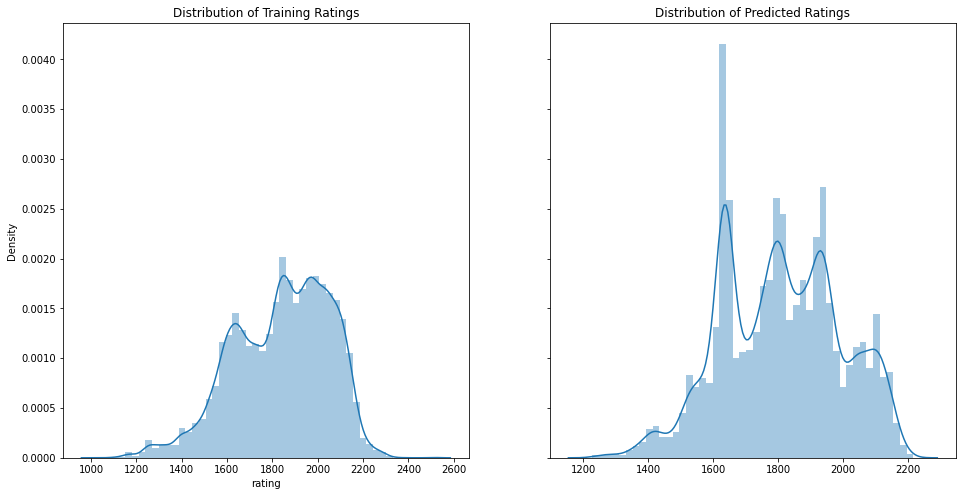

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16,8))
sns.distplot(train['rating'], ax=axs[0])
axs[0].set_title("Distribution of Training Ratings")
sns.distplot(final_preds , ax=axs[1])
axs[1].set_title("Distribution of Predicted Ratings")

In [ ]:
test['rating'] = final_preds
submission = test['rating']

path_save = '/content/drive/MyDrive/머신러닝 엔지니어링/Kaggle/Scrabble Player Rating/submission/'
submission.to_csv(path_save + "submission_optuna_LGBM.csv")

In [ ]:
submission

game_id
2        1976.971409
7        1937.503328
11       1831.060307
14       1839.620779
27       2099.928414
            ...     
72760    2108.969953
72761    1627.375642
72762    1552.650363
72768    2054.877752
72769    1888.068375
Name: rating, Length: 22363, dtype: float64